# SU(2) Model

See, for example:
- https://journals.aps.org/prd/abstract/10.1103/PhysRevD.21.2308
- https://www.sciencedirect.com/science/article/pii/0010465581900862

In [2]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

if 'root_dir' not in locals():
    # Navigate to examples/SU2Model directory as simulation root directory
    import os
    os.chdir("../examples/SU2Model")
    root_dir = os.getcwd()

# To be able to compute custom measures
import sys
sys.path.append("./../../python_scripts")
    
mcmc_model_dir = "SU2ModelMetropolis/"
mcmc_data_dir = root_dir + "/data/" + mcmc_model_dir
mcmc_results_dir = root_dir + "/results/" + mcmc_model_dir

data_dir = root_dir + "/data/" + mcmc_model_dir
results_dir = root_dir + "/results/" + mcmc_model_dir

## MCMC Results

### Expectation Values

In [3]:
from mcmctools.modes.expectation_value import load_expectation_value_results
expectation_values = load_expectation_value_results(files_dir="SU2ModelMetropolis")
# Insert Beta as column (as floating number)
expectation_values.insert(0, "Beta", expectation_values.index.values.astype(np.float))
expectation_values

Quantity,Beta,ExpVal,Error
Observable,,AveragePlaquetteAction,AveragePlaquetteAction
beta,,,
1.700000,1.7,0.995640,0.000600
2.000000,2.0,0.997957,0.000876
2.300000,2.3,0.902562,0.001077
2.600000,2.6,0.853788,0.000864
2.900000,2.9,0.832047,0.000873


In [4]:
average_plaquette = expectation_values.apply(lambda x: x / expectation_values["Beta"])
average_plaquette

Quantity,Beta,ExpVal,Error
Observable,,AveragePlaquetteAction,AveragePlaquetteAction
beta,,,
1.700000,1.0,0.585671,0.000353
2.000000,1.0,0.498979,0.000438
2.300000,1.0,0.392418,0.000468
2.600000,1.0,0.328380,0.000332
2.900000,1.0,0.286913,0.000301


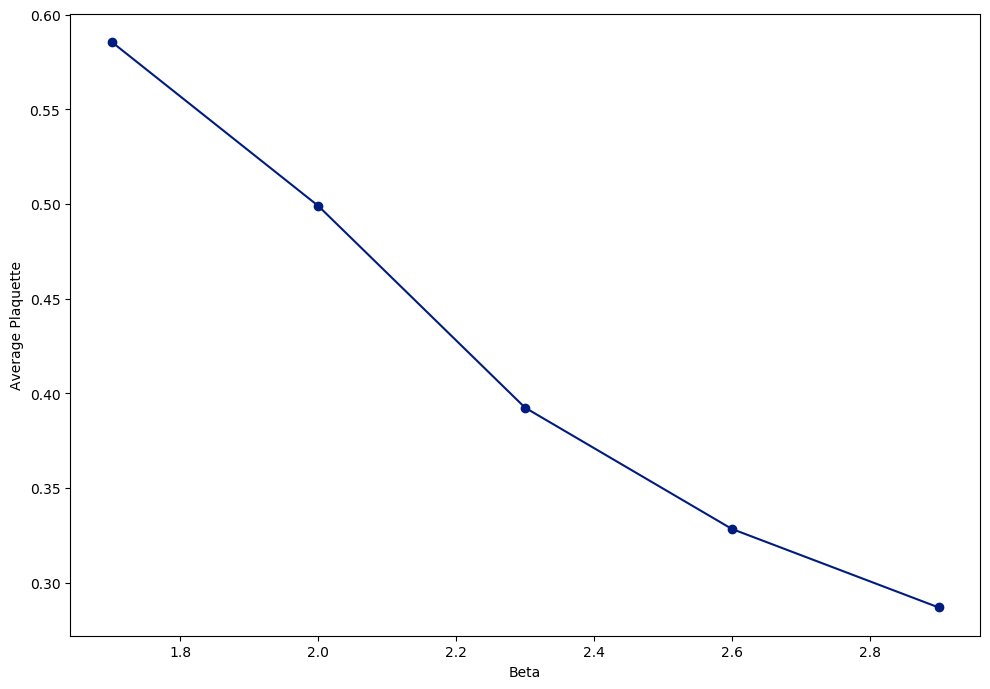

In [5]:
fig, ax = fma.newfig(1.4, figsize=(10, 7))

ax.plot(expectation_values["Beta"], average_plaquette["ExpVal", "AveragePlaquetteAction"], "o-")

ax.set_xlabel("Beta")
ax.set_ylabel("Average Plaquette")

plt.tight_layout()

fma.savefig(results_dir, "average_plaquette")

## Configurations as Pytorch Dataset

We show how the mcmc configurations can be stored and loaded as a .pt file.

(See also python_scripts/loading_configurations.py and python_scripts/pytorch_data_generation.py)

### Preparation

In [6]:
data_generator_args = {
    # ConfigDataGenerator Args
    "data_type": "target_param",
    # Args for ConfigurationLoader
    "path": mcmc_data_dir,
    "total_number_of_data_per_file": 500,
    "identifier": "expectation_value",
    "running_parameter": "beta"
    # "chunksize": 100  # If no chunksize is given, all data is loaded at once
}

# Prepare in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import prepare_in_memory_dataset
from mcmctools.pytorch.data_generation.datagenerationroutines import data_generator_factory

prepare_in_memory_dataset(
    root=data_dir,
    batch_size=89,
    data_generator_args=data_generator_args,
    data_generator_name="BatchConfigDataGenerator",
    data_generator_factory=data_generator_factory
)

Random seed is set by np.random.seed()


### Generating and Loading the Dataset

In [7]:
# Load in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import load_in_memory_dataset

# The dataset is generated and stored as a .pt file in the data_dir/data directory the first time this function is called. Otherwise the .pt is loaded.
data_loader = load_in_memory_dataset(
    root=data_dir, batch_size=16, data_generator_factory=data_generator_factory, slices=None, shuffle=True,
    num_workers=0, rebuild=False
    # sample_data_generator_name="ConfigDataGenerator"  # optional: for a generation of new samples
)

# Load training data
for batch_idx, batch in enumerate(data_loader):
    data, target = batch
    # print(batch_idx, len(data))

Processing...
Random seed is set by np.random.seed()
Done!


### Inspection of the Dataset - Sample Visualization

In [8]:
from pystatplottools.visualization import sample_visualization

config_dim = (64, 64)  # Dimension of the data
ab = (-1, 1)  # Data is expected to be in the range (-1, 1)

# Random samples
config, label = data_loader.dataset.get_random_sample()
batch, batch_label = data_loader.dataset.get_random_batch(108)

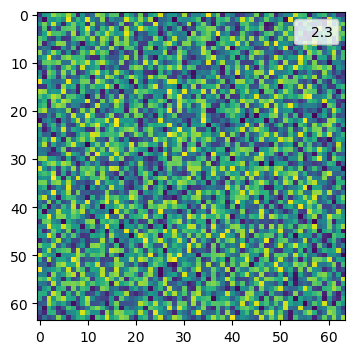

In [9]:
# Single Sample
sample_visualization.fd_im_single_sample(sample=config, label=label, config_dim=config_dim, ab=ab,
                                         fma=fma, filename="single_sample", directory=results_dir, figsize=(10, 4));

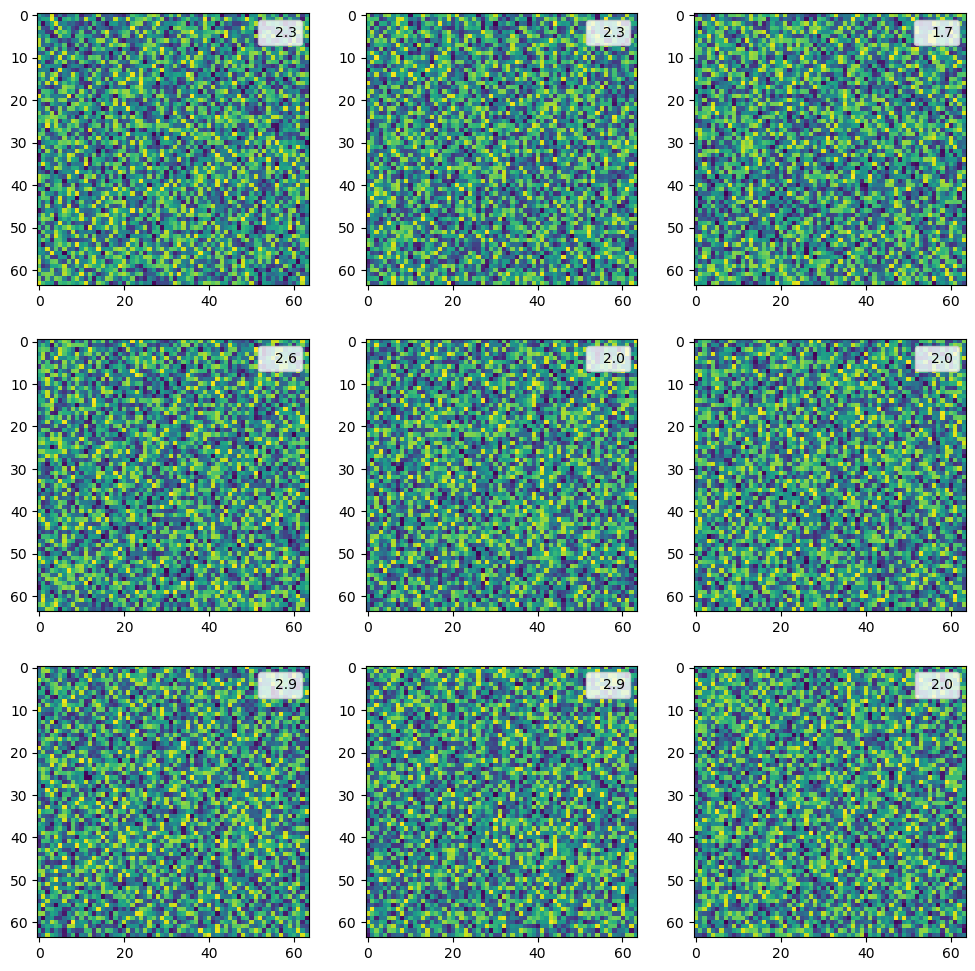

In [10]:
# Batch with labels
sample_visualization.fd_im_batch(batch, batch_labels=batch_label, num_samples=9, dim=(3, 3),
                                 config_dim=config_dim, ab=ab,
                                 fma=fma, filename="batch", directory=results_dir, width=2.3, ratio=1.0, figsize=(12, 12));

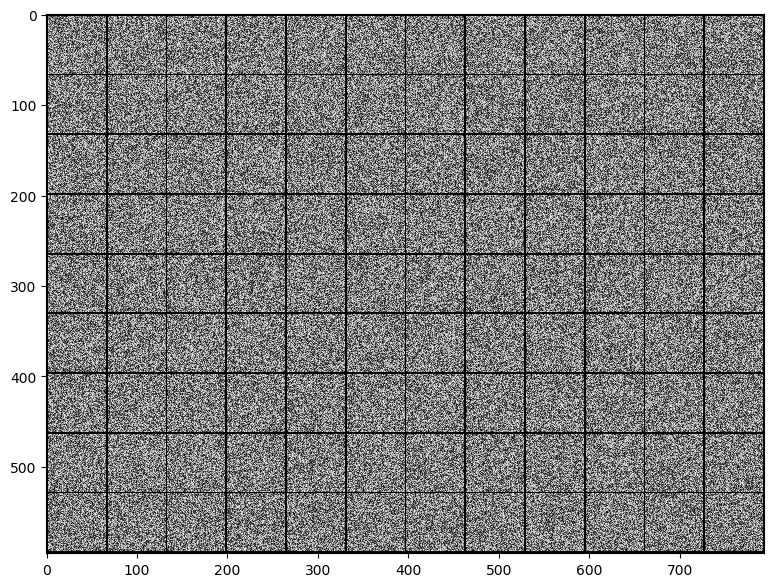

In [11]:
# Batch grid
sample_visualization.fd_im_batch_grid(batch, config_dim=config_dim, ab=ab,
                                      fma=fma, filename="batch_grid", directory=results_dir);